In [2]:
import gpu_picker
print(gpu_picker.gpu_memory_map())
print(gpu_picker.list_available_gpus())
print(gpu_picker.pick_gpu_lowest_memory())
gpu_picker.setup_one_gpu()

ModuleNotFoundError: No module named 'gpu_picker'

<h1>Run Leaderboard Example</h1>


In [1]:
import os
import numpy as np
import skimage.io
import skimage.transform
import tensorflow
import run_leaderboard  #this is currently referencing the multi-GPU model for VGG
np.random.seed(21)
tensorflow.set_random_seed(21)
os.environ['CUDA_VISIBLE_DEVICES']='7'

Using TensorFlow backend.


<h2>Process the Data</h2>

In [2]:
# Parameters
training_dataset_path = "dataset_updated/training_set"
test_dataset_path = "dataset_updated/validation_set"
wild_test_dataset_path = 'wild_test'

# categories to use
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
n_categories = len(categories)
category_embeddings = {
    'drawings': 0,
    'engraving': 1,
    'iconography': 2,
    'painting': 3,
    'sculpture': 4
}

# set width, height, RGB
width = 100 
height = 100 
n_channels = 3

training_data = []
for cat in categories:
    files = os.listdir(os.path.join(training_dataset_path, cat))
    for file in files:
        training_data += [(os.path.join(cat, file), cat)]

test_data = []
for cat in categories:
    files = os.listdir(os.path.join(test_dataset_path, cat))
    for file in files:
        test_data += [(os.path.join(cat, file), cat)]
        


In [3]:

    
# Load all images to the same format (takes some time)
def load_dataset(tuples_list, dataset_path):
    indexes = np.arange(len(tuples_list))
    np.random.shuffle(indexes)
    
    X = []
    y = []
    n_samples = len(indexes)
    cpt = 0
    for i in range(n_samples):
        t = tuples_list[indexes[i]]
        try:
            img = skimage.io.imread(os.path.join(dataset_path, t[0]))
            img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
            X += [img]
            y_tmp = [0 for _ in range(n_categories)]
            y_tmp[category_embeddings[t[1]]] = 1
            y += [y_tmp]
        except OSError:
            pass
        
        cpt += 1
        
        if cpt % 1000 == 0:
            print("Processed {} images".format(cpt))

    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [4]:
import warnings
import skimage

#this is a hack b/c there are warnings from skimage that are being emitted

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_train, y_train = load_dataset(training_data, training_dataset_path)
    X_val, y_val = load_dataset(test_data, test_dataset_path)

print("Your train and val shapes...")
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Your train and val shapes...
(7721, 100, 100, 3)
(7721, 5)
(856, 100, 100, 3)
(856, 5)


In [5]:
###declare your augmentations

myaugs = dict(featurewise_center=True,
                 featurewise_std_normalization=True,
                 rotation_range=90.,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 zoom_range=0.2)


<h2>Here we have a function to automatically build, compile, train, and evaluate a CNN</h2>

In [6]:
#function to create any number of CNN's based on batch_size and epochs
def make_cnns(batch_size, epochs, optimizer):
            
        cnn_object = run_leaderboard.make_leaderboard(X_train = X_train, 
                                y_train = y_train, 
                                X_val = X_val, 
                                y_val = y_val, 
                                data_name = 'art_data', 
                                augs = myaugs, 
                                width =100, 
                                height = 100, 
                                channels = 3, 
                                optimizer = optimizer, 
                                loss = 'categorical_crossentropy', 
                                metrics = 'accuracy', 
                                classes = 5, 
                                n_classes = 5, #same as classes
                                batch_size = batch_size, 
                                model_network_name = 'art_cnn',
                                epochs = epochs, 
                                patience = 3, 
                                logfile = 'cnn_log',
                                save_folder = 'test')

        art_data, xtr_shape, ytr_shape, xval_shape, yval_shape, data_augs, art_train_datagen = cnn_object.register_the_data()
        art_model_cnn, art_cnn = cnn_object.build_and_compile_CNN(model_type='cnn')
        art_cnn_fitter, art_cnn_history, art_cnn_log = cnn_object.fit_model(model_network = art_cnn, train_datagen = art_train_datagen, fit_type = 'nostop') 
        art_cnn_metrics, yhat_predictions_art, yhat_classes_art, cnn_accuracy, cnn_precision, cnn_recall = cnn_object.evaluate_model(history=art_cnn_history, 
                                                                                                                             metrics_name='art_cnn_metrics', 
                                                                                                                             model_network = art_cnn)
        cnn_configs = cnn_object.model_configs(data_object = art_data,
                                                model_object = art_model_cnn,
                                                model_network = art_cnn,
                                                xtr_shape = xtr_shape, 
                                                ytr_shape = ytr_shape, 
                                                xval_shape = xval_shape, 
                                                yval_shape = yval_shape, 
                                                fitter_object = art_cnn_fitter, 
                                                logfile = art_cnn_log, 
                                                acc = cnn_accuracy, 
                                                prec = cnn_precision, 
                                                rec = cnn_recall)
        return cnn_configs.model_df



<h2>Same thing for a VGG</h2>

In [7]:
def make_vggs(batch_size, epochs, optimizer):
        vgg_object = run_leaderboard.make_leaderboard(X_train = X_train, 
                                y_train = y_train, 
                                X_val = X_val, 
                                y_val = y_val, 
                                data_name = 'art_data', 
                                augs = myaugs, 
                                width =100, 
                                height = 100, 
                                channels = 3, 
                                optimizer = optimizer, 
                                loss = 'categorical_crossentropy', 
                                metrics = 'accuracy', 
                                classes = 5, 
                                n_classes = 5, #same as classes
                                batch_size = batch_size, 
                                model_network_name = 'art_vgg',
                                epochs = epochs, 
                                patience = 3,
                                logfile = 'vgg_log',
                                save_folder='test')    

        art_data, xtr_shape, ytr_shape, xval_shape, yval_shape, data_augs, art_train_datagen = vgg_object.register_the_data()
        art_model_vgg, art_vgg = vgg_object.build_and_compile_CNN(model_type='vgg')
        art_vgg_fitter, art_vgg_history, art_vgg_log = vgg_object.fit_model(art_vgg, art_train_datagen, fit_type = 'early')
        art_vgg_metrics, yhat_predictions_art, yhat_classes_art, vgg_accuracy, vgg_precision, vgg_recall = vgg_object.evaluate_model(history=art_vgg_history, 
                                                                                                                             metrics_name='art_vgg_metrics', 
                                                                                                                             model_network = art_vgg)
        
        vgg_configs = vgg_object.model_configs(data_object = art_data,
                                                model_object = art_model_vgg,
                                                model_network = art_vgg,
                                                xtr_shape = xtr_shape, 
                                                ytr_shape = ytr_shape, 
                                                xval_shape = xval_shape, 
                                                yval_shape = yval_shape, 
                                                fitter_object = art_vgg_fitter, 
                                                logfile = art_vgg_log, 
                                                acc = vgg_accuracy, 
                                                prec = vgg_precision, 
                                                rec = vgg_recall)
        return vgg_configs.model_df



<h2>Let's run the above script to output a Dataframe for a single CNN</h2>

Generated Basic CNN for:art_cnn
Epoch 1/2
242/241 [==============================] - 65s 268ms/step - loss: 0.9245 - acc: 0.6481 - val_loss: 1.2459 - val_acc: 0.5070
Epoch 2/2
856/856 [==============================] - 2s 2ms/step
Accuracy is: [0.9032696992437416, 0.6822429912112583]
856/856 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.38      0.50       230
           1       0.29      0.73      0.41        33
           2       0.78      0.89      0.83       203
           3       0.63      0.97      0.76       148
           4       0.77      0.61      0.68       242

   micro avg       0.68      0.68      0.68       856
   macro avg       0.64      0.72      0.64       856
weighted avg       0.72      0.68      0.67       856

0.8971662372259586
Accuracy plot saved.
Loss curve saved.
Confusion matrix saved.
ROC curves saved.


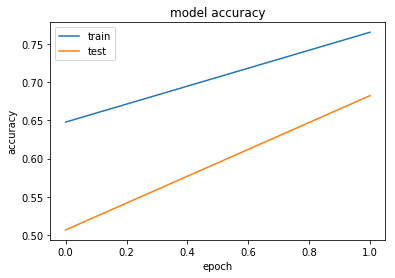

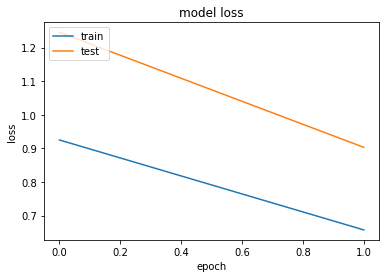

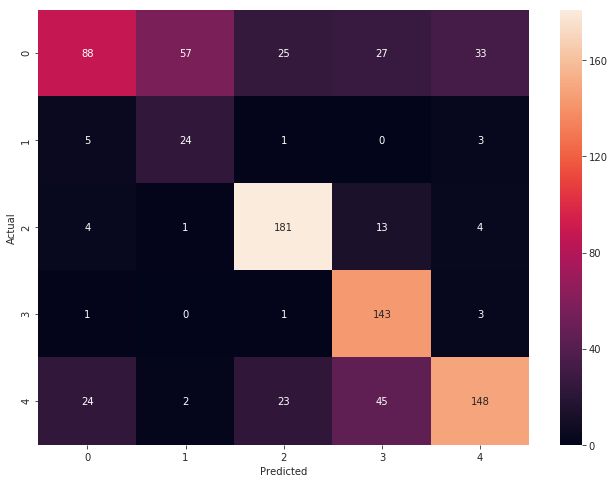

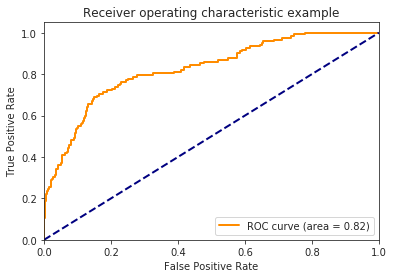

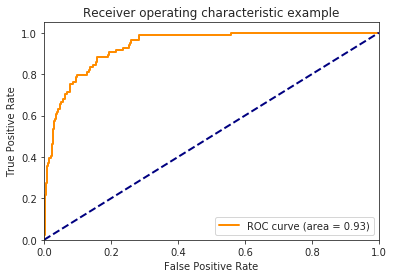

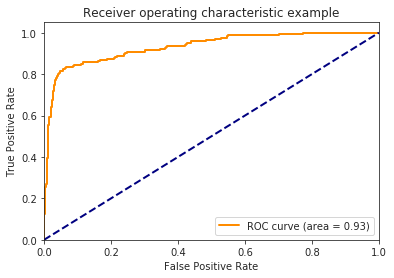

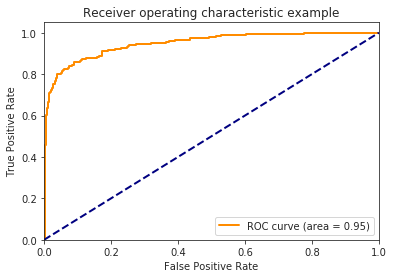

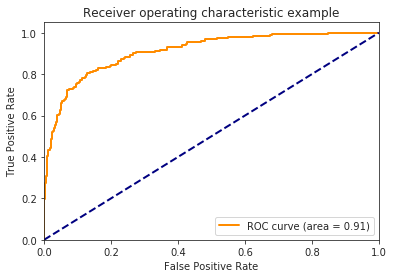

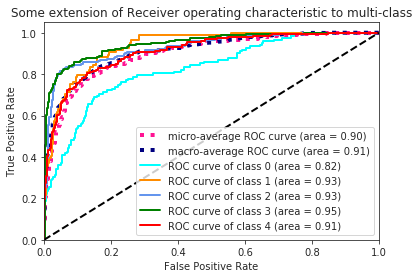

/mnt/nfs_share/SHARED/mfagundo/Github/keras_leaderboard/keras_leaderboard.py:440: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  ], axis=1)


In [8]:
cnn1 = make_cnns(32, 2, 'adam')

<h2>Let's do the same thing for a VGG</h2>

Generated VGG_16 for:art_vgg
Epoch 1/5
242/241 [==============================] - 98s 405ms/step - loss: 0.6037 - acc: 0.7777 - val_loss: 0.5279 - val_acc: 0.8154

Epoch 00001: val_loss improved from inf to 0.52795, saving model to test/art_vgg_5-2-14-35/models/weights.01-0.53.hdf5
Epoch 2/5
242/241 [==============================] - 98s 404ms/step - loss: 0.4014 - acc: 0.8506 - val_loss: 0.4856 - val_acc: 0.8107

Epoch 00002: val_loss improved from 0.52795 to 0.48560, saving model to test/art_vgg_5-2-14-35/models/weights.02-0.49.hdf5
Epoch 3/5
242/241 [==============================] - 99s 409ms/step - loss: 0.3398 - acc: 0.8733 - val_loss: 0.3825 - val_acc: 0.8505

Epoch 00003: val_loss improved from 0.48560 to 0.38248, saving model to test/art_vgg_5-2-14-35/models/weights.03-0.38.hdf5
Epoch 4/5
242/241 [==============================] - 98s 405ms/step - loss: 0.3118 - acc: 0.8823 - val_loss: 0.3521 - val_acc: 0.8645

Epoch 00004: val_loss improved from 0.38248 to 0.35208, saving mod

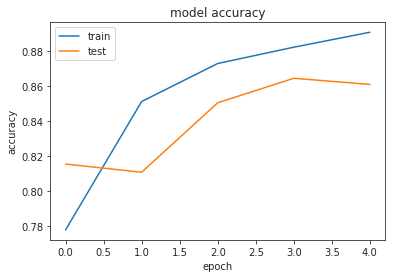

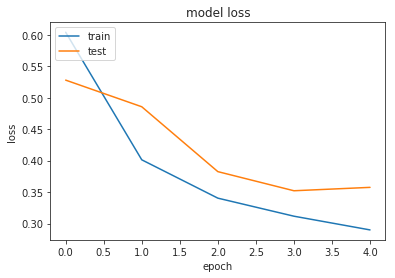

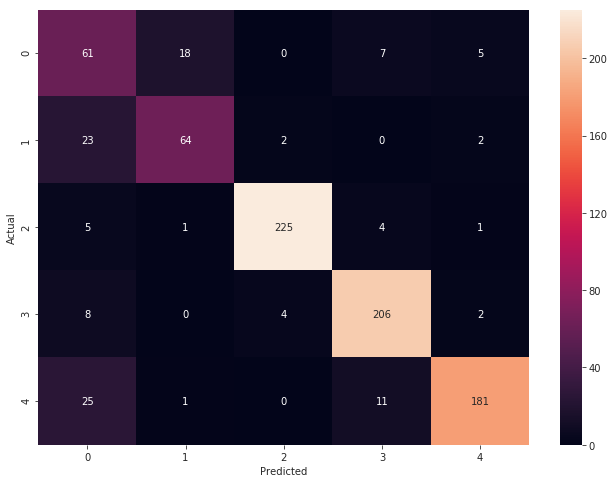

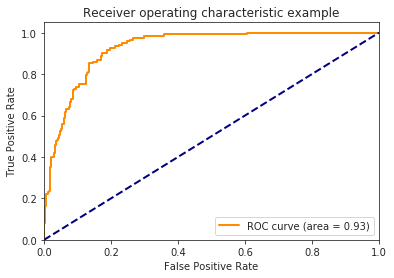

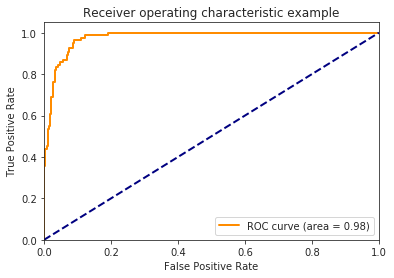

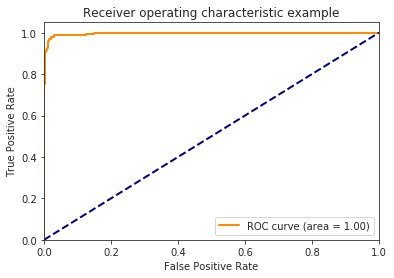

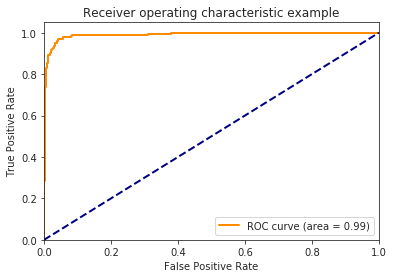

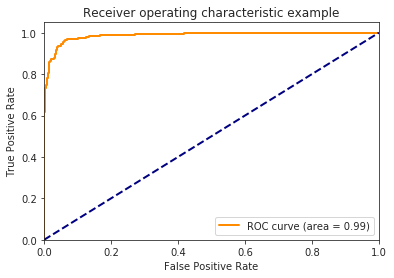

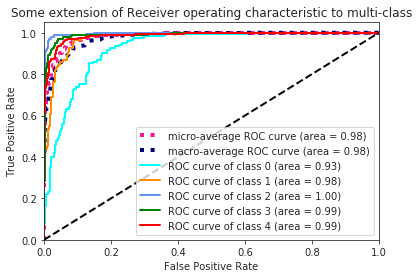

Something went wrong, here's an empty dataframe


/mnt/nfs_share/SHARED/mfagundo/Github/keras_leaderboard/keras_leaderboard.py:440: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  ], axis=1)


In [ ]:
vgg1 = make_vggs(32, 5, 'adam')

In [ ]:
cnn1

,data_name,model_name,model_val_acc,model_prec,model_recall,myaugs,xtrain_shape,ytrain_shape,xval_shape,yval_shape,image_width,image_height,image_channels,model optimizer,model_loss_metric,num_classes,model_batchsize,num_epochs,model_training_log
0,art_data,art_cnn,Figure(432x288),"[0.3826086956521739, 0.7272727272727273, 0.891...","[0.7213114754098361, 0.2857142857142857, 0.783...","{'featurewise_center': True, 'featurewise_std_...","art_data_X_train_(7721, 100, 100, 3)","art_data_y_train_(7721, 5)","art_data_X_val_(856, 100, 100, 3)","art_data_y_val_(856, 5)",100,100,3,adam,categorical_crossentropy,5,32,2,epoch acc loss val_acc val_lo...


In [ ]:
vgg1

,data_name,model_name,model_val_acc,model_prec,model_recall,myaugs,xtrain_shape,ytrain_shape,xval_shape,yval_shape,image_width,image_height,image_channels,model optimizer,model_loss_metric,num_classes,model_batchsize,num_epochs,model_training_log
0,art_data,art_vgg,Figure(432x288),"[0.6703296703296703, 0.7032967032967034, 0.953...","[0.5, 0.7619047619047619, 0.974025974025974, 0...","{'featurewise_center': True, 'featurewise_std_...","art_data_X_train_(7721, 100, 100, 3)","art_data_y_train_(7721, 5)","art_data_X_val_(856, 100, 100, 3)","art_data_y_val_(856, 5)",100,100,3,adam,categorical_crossentropy,5,32,5,epoch acc loss val_acc val_lo...


<h2>Let's create some more with different batch_size, epochs, optimizer</h2>

In [ ]:
cnn2 = make_cnns(4, 10, 'sgd')

Generated Basic CNN for:art_cnn
Epoch 1/10
1931/1930 [==============================] - 102s 53ms/step - loss: 0.9404 - acc: 0.6419 - val_loss: 0.9983 - val_acc: 0.6192
Epoch 2/10
1227/1930 [==================>...........] - ETA: 36s - loss: 0.7347 - acc: 0.7357

In [ ]:
vgg2 = make_cnns(64, 10, 'sgd')

In [ ]:
vgg3 = make_vggs(32, 15, 'adam')

In [ ]:
#Let's make some more

cnn3 = make_cnns(2, 20, 'sgd')

In [ ]:
cnn4 = make_cnns(32, 20, 'sgd')


In [ ]:
cnn5 = make_cnns(64, 30, 'adam')


In [ ]:
cnn6 = make_cnns(64, 50, 'adagrad')


In [ ]:
vgg4 = make_vggs(32, 20, 'adagrad')

In [ ]:
vgg5 = make_vggs(32, 30, 'adam')


In [ ]:
vgg6 = make_vggs(32, 50, 'adam')

<h2>Append it to a larger dataframe</h2>

In [23]:
import qgrid #https://github.com/quantopian/qgrid for interactive graphs uses node.js package in anaconda

In [37]:
vgg6

,data_name,model_name,model_val_acc,model_prec,model_recall,myaugs,xtrain_shape,ytrain_shape,xval_shape,yval_shape,image_width,image_height,image_channels,model optimizer,model_loss_metric,num_classes,model_batchsize,num_epochs,model_training_log
0,art_data,art_vgg,0.867991,"[0.6363636363636364, 0.7294117647058823, 0.953...","[0.6311475409836066, 0.7380952380952381, 0.974...","{'featurewise_center': True, 'featurewise_std_...","art_data_X_train_(7721, 100, 100, 3)","art_data_y_train_(7721, 5)","art_data_X_val_(856, 100, 100, 3)","art_data_y_val_(856, 5)",100,100,3,adam,categorical_crossentropy,5,32,50,epoch acc loss val_acc val_l...


In [41]:
 ##append into a larger leaderboard

lb_Apr7 = cnn1.append([cnn2, cnn3, cnn4, cnn5, cnn6, vgg1, vgg2, vgg3, vgg4, vgg5, vgg6], ignore_index=True)
lb_Apr7.to_csv('lb_Apr7.csv')


In [ ]:
#reloading to test
#import pandas as pd
#lb_Mar17 = pd.read_csv('lb_Mar17.csv', index_col=0)

In [42]:
lb_Apr7.columns

Index(['data_name', 'model_name', 'model_val_acc', 'model_prec',
       'model_recall', 'myaugs', 'xtrain_shape', 'ytrain_shape', 'xval_shape',
       'yval_shape', 'image_width', 'image_height', 'image_channels',
       'model optimizer', 'model_loss_metric', 'num_classes',
       'model_batchsize', 'num_epochs', 'model_training_log'],
      dtype='object')

In [43]:
df1 = lb_Apr7[['data_name', 'model_name', 'model_val_acc', 'model_prec', 'model_recall', 'model optimizer', 'model_loss_metric', 'model_batchsize', 'num_epochs']]


In [45]:
qgrid_widget1 = qgrid.show_grid(df1, show_toolbar=True)
qgrid_widget1

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [54]:
vgg5.model_prec[0]


array([0.60839161, 0.80555556, 0.93442623, 0.96116505, 0.92146597])